# Sprint7課題 機械学習スクラッチクラスタリング

### 1. この課題の目的

- スクラッチを通してK-meansを理解する
- クラスタ分析を行う

### 2.スクラッチによる実装

### 【問題1】K-meansクラスの作成

非階層クラスタリングの手法であるK-meansのクラスを作成する。（名前はScratchKMeansとする）

教師なし学習であるクラスタリングになるため、ここまでの回帰や分類とは異なるパイプラインを作成することになる。

メソッドやパラメータなどはscikit-learnを参考にすること。

[sklearn.cluster.KMeans — scikit-learn 0.20.0 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

検証段階ではJupyter Notebook上で書き、最終的にはpyファイルにモジュールとしてまとめる。

#### ユークリッド距離

K-menasにおける**近い**とは点と点のユークリッド距離が小さくなること。

ユークリッド距離とはピタゴラスの定理（三平方の定理）で求められるものですが、ベクトル$p$, $q$に対しては以下の数式で表現できる。

<br>


<div style="text-align:center">
$\|q-p\| = \sqrt{(q-p)\cdot(q-p)}$
</div>


NumPyにはこの関数がnp.linalg.normとして用意されており、これを使用する。

参考 [numpy.linalg.norm — NumPy v1.15 Manual](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.linalg.norm.html)

#### 初期値
K-meansの学習結果は中心点 $μ$の初期値に影響を受ける。

最もシンプルな初期値の決定方法は、データ点 $X_n$の中からランダムに $k$個選ぶことです。今回はこれを実装する。

K-meansのより良い初期値の選択方法については研究が行われており、いろいろな方法が提案されている。

#### 推定

新たなデータに対してどのクラスタに所属するかの推定の際は、学習時の1つ目のフェーズと同じことを行う。

- データ点 $X_n$に対し、学習で決まった中心点 $μ_k$の元、 $J$を最小化する $r_{nk}$を選ぶ。

具体的には次のことです。

- データ点 $X_n$ を最も近い $μ_k$に割り当てる。

In [1]:
import sys

sys.path.append('/Users/makintosh/diveintocode-term1/ml-scratch')

# 演算
import numpy as np
import pandas as pd

# 可視化
import matplotlib.pyplot as plt
import seaborn as sns
from utils.decision_region import decision_region

# クラスタリング
from utils.ScratchKMeans import ScratchKMeans

# 機械学習
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from tqdm import tqdm_notebook as tqdm

%matplotlib inline

### クラスタリングのための人工データセット

クラスタリングを実験するための人工データセットを作成するコードを用意したので、スクラッチの過程で利用する。

このmake_blobs関数は正解ラベルも出力しているが、今回は使用しない。

使用しないことを明示するために、 _（アンダースコア） で受け取っている。

In [2]:
# simple dataset 3
from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)

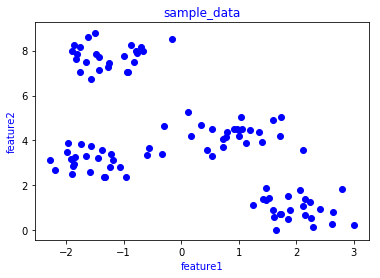

In [3]:
# plot
plt.scatter(X[:, 0], X[:, 1], color = "b")
plt.title("sample_data", color = "b")
plt.xlabel("feature1", color = "b")
plt.ylabel("feature2", color = "b")
plt.show()

- 直観的には４分割が妥当に思える。

### データを分割する

In [4]:
# 学習用データ、検証用データを作成する
X_train, X_test = train_test_split(X, test_size=0.2)

### 目的関数

K-meansは以下のクラスタ内誤差平方和（SSE, Sum of Squared Errors）を最小化する $r_{nk}$と$μ_k$を求めることで学習を行う。

この数式自体は学習時にはコーディングする必要はないが、クラスタ数$K$を決めるためのエルボー法で使う。

エルボー法の実装は問題2で扱う。

<br>

<div style="text-align:center;">
$SSE = \sum_{n=1}^N \sum_{k=1}^K r_{nk} \|X_n - \mu_k\|^2$
</div>

- $n$ : データ点のインデックス

- $k$ : クラスタのインデックス

- $X_n$ : $n$番目のデータ点

- $μ_k$ : $k$番目の中心点

- $r_{nk}$ : データ点

- $X_n$がクラスタ$k$に所属していたら1、そうでなければ0

### 学習・予測を行う

In [5]:
# インスタンス生成
clf = ScratchKMeans(n_clusters=4, max_iter=20, random_state=0)

In [6]:
# 学習
clf.fit(X_train)

In [7]:
# 予測
X_pred = clf.predict(X_test)
X_pred

array([1, 3, 0, 3, 3, 2, 2, 2, 0, 0, 3, 3, 0, 1, 0, 1, 0, 1, 3, 2])

In [8]:
clf.silhouette_vals.shape

(80,)

### 可視化

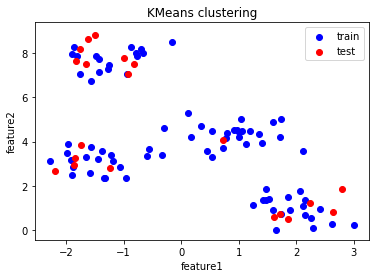

In [9]:
# 可視化
plt.scatter(X_train[:, 0], X_train[:, 1], color = "b", label = "train")
plt.scatter(X_test[:, 0], X_test[:, 1], color = "r", label = "test")
plt.title("KMeans clustering")
plt.xlabel("feature1")
plt.ylabel("feature2")
plt.legend()
plt.show()

### 疑問

- モデルの分類精度は乱数のシード値にも左右されると思われるので、複数のシード値を用いて分類結果がどのように変化するか検証した。

random_state : 0


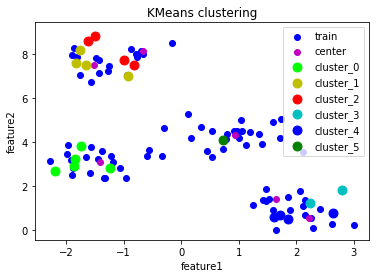

random_state : 1


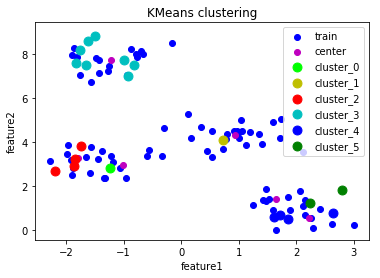

random_state : 2


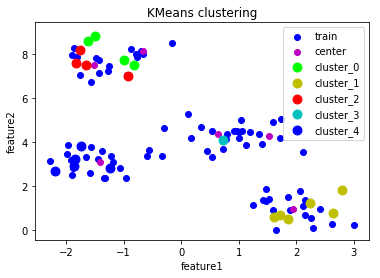

random_state : 3


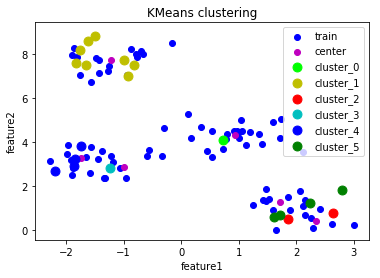

random_state : 4


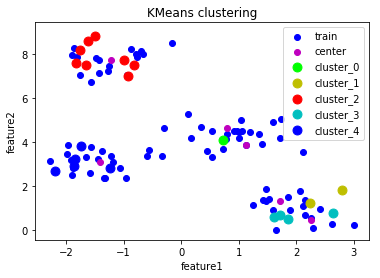

random_state : 5


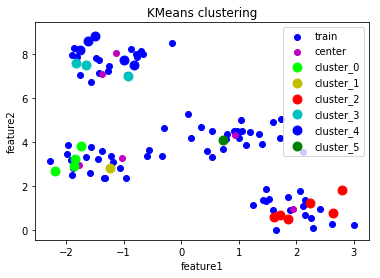

In [10]:
# 乱数生成のシード値を変える
for seed in range(6):
    clf = ScratchKMeans(n_clusters=6, max_iter=20, random_state=seed)
    print("random_state : {}".format(seed))
    clf.fit(X_train)
    X_pred = clf.predict(X_test)
    centers = np.array(clf.centers)

    # パラメータ
    target_names = ["0", "1", "2", "3", "4", "5"]
    pred_color = ["lime", "y", "r", "c", "b", "g"]
    pred_names = ["cluster_" + target_name for target_name in target_names]

    # 可視化
    plt.scatter(X_train[:, 0], X_train[:, 1], color = "b", label = "train")
    plt.scatter(centers[:, 0], centers[:, 1], color = "m", label = "center")

    for i, target in enumerate(set(X_pred)):
            plt.scatter(X_test[X_pred==target][:, 0],X_test[X_pred==target][:, 1],
                        s=80, color=pred_color[i], label=pred_names[i], marker='o')

    plt.title("KMeans clustering")
    plt.xlabel("feature1")
    plt.ylabel("feature2")
    plt.legend()
    plt.show()

### 【問題2】エルボー法の実装

K-meansにおいて中心点の個数$k$は人為的に決める必要があるが、その判断方法としてエルボー法がある。

SSEを縦軸、クラスタ数$k$を横軸にした折れ線グラフを表示する。

このためにK-meansのインスタンスからはSSEを取得できるようにすること。

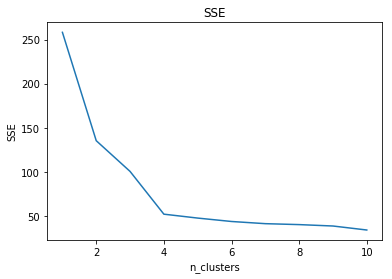

In [11]:
# 可視化
n_clusters = 10
sse = []

for i in range(1, n_clusters+1):
    clf = ScratchKMeans(max_iter=20, n_clusters = i)
    clf.fit(X_train)
    sse.append(clf.loss)

plt.plot(np.arange(1, n_clusters+1), sse)
plt.title("SSE")
plt.xlabel("n_clusters")
plt.ylabel("SSE")
plt.show()

- クラスタ数4以降でSSEの減少幅が緩やかになっており、最適なクラスタ数は４と考えられる。

### 【問題3】（アドバンス課題）シルエット図

$k$を決める助けになるものとしてシルエット図もある。

Matplotlibを使い可視化するコードを用意した。（引数に以下を与える必要がある）。

- silhouette_vals : shape(n_samples,)のndarray、各データ点のシルエット係数

- silhouette_avg : float、シルエット係数の平均値

- y_km : shape(n_samples,)のndarray、各データ点のクラスタラベル名

- cluster_labels : list、クラスタのラベル名のリスト

- n_clusters : int、クラスタ数

$n$番目のデータ点に対するシルエット係数 $s_n$は以下の数式で求められる。

この数式を実装し、シルエット図を確認すること。

<br>

<div style="text-align: center;">
$s_n = \frac{b_n-a_n}{max(b_n,a_n)}$
</div>

- $a_n$ : 凝集度。同じクラスタ内の他のデータ点との距離の平均値。

- $b_n$ : 乖離度。最も近い他のクラスタ内の全てのデータ点との距離の平均値。

乖離度 $b$が大きく、凝集度$a$が小さい時が理想的であり、シルエット係数 $s$は1に近くなる。

In [12]:
#　インスタンス生成
clf_new = ScratchKMeans(max_iter=20, n_clusters=4, random_state=3)

In [13]:
# 学習
clf_new.fit(X_train)

In [14]:
# 予測
X_pred = clf_new.predict(X_test)
X_pred

array([1, 2, 3, 2, 2, 1, 1, 1, 0, 3, 2, 2, 3, 1, 3, 1, 3, 1, 2, 1])

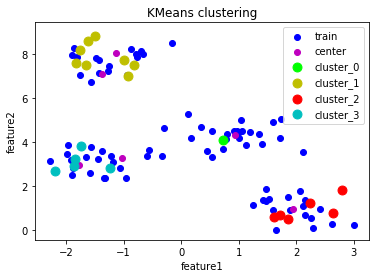

In [15]:
# パラメータ
target_names = ["0", "1", "2", "3", "4", "5"]
pred_color = ["lime", "y", "r", "c", "b" "g"]
pred_names = ["cluster_" + target_name for target_name in target_names]

# 可視化
plt.scatter(X_train[:, 0], X_train[:, 1], color = "b", label = "train")
plt.scatter(centers[:, 0], centers[:, 1], color = "m", label = "center") # 中心点

for i, target in enumerate(set(X_pred)):
        plt.scatter(X_test[X_pred==target][:, 0],X_test[X_pred==target][:, 1],
                    s=80, color=pred_color[i], label=pred_names[i], marker='o')

plt.title("KMeans clustering")
plt.xlabel("feature1")
plt.ylabel("feature2")
plt.legend()
plt.show()

In [16]:
# 各データ点のシルエット係数
silhouette_vals = clf_new.silhouette_vals

In [17]:
# シルエット係数の平均値
silhouette_avg = np.mean(silhouette_vals)
silhouette_avg

0.692753463783346

In [18]:
# 各データ点のクラスタラベル名
y_km = clf_new.label

In [19]:
cluster_labels = clf_new.cluster_labels
cluster_labels

[0, 1, 2, 3]

In [20]:
n_clusters = clf_new.n_clusters
n_clusters

4

yticks : [12.0]
yticks : [12.0, 32.5]
yticks : [12.0, 32.5, 50.5]
yticks : [12.0, 32.5, 50.5, 70.0]


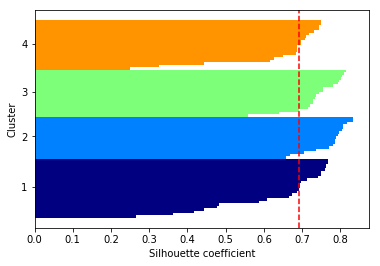

In [21]:
from matplotlib import cm

y_ax_lower, y_ax_upper = 0, 0
yticks = []

for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    print("yticks : {}".format(yticks))
    y_ax_lower += len(c_silhouette_vals)

plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, np.array(cluster_labels) + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()

- 各クラスタのシルエット図の形状が類似しており、また、シルエット係数の平均値が0.7程度であることから、妥当なクラスタリングがなされていると考える。

### 【問題4】クラスタ数kの選択

最適だと思われるクラスタ数$k$を選択する。

エルボー法やシルエット図を活用する他、人間が後々どう利用したいのかも選択に関わる。

選択した上で、なぜそれを選んだか説明すること。

### 卸売業者のデータ分析
クラスタリングの利用法を学ぶために、Wholesale customers Data Setを使用する。

[UCI Machine Learning Repository: Wholesale customers Data Set](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers)

Data Folderの中からWholesale customers data.csvをダウンロードすること。

これはポルトガルのリスボンにある卸売業者（wholesale）が顧客から集めたデータで、各顧客が年間でミルクや食料品を何ユーロ購入しているかを示したものである。（顧客は小売店やレストラン）

RegionとChannelは取り覗き、金額のデータでK-meansを利用する。

In [22]:
# データセットの準備
df = pd.read_csv("Wholesale_customers_data.csv")

# 総計を追加したデータフレーム
df_new = pd.concat([df,pd.DataFrame(df.sum(axis=1),columns=['Total_expense'])],axis=1)

# 地域別データセット
df_Lisbon = df[df["Region"] == 1]
df_Oporto = df[df["Region"] == 2]
df_Other = df[df["Region"] == 3]

# チャネル別セット
df_Hotel = df[df["Channel"] == 1]
df_Retail = df[df["Channel"] == 2]

# 金額のみ抽出
df_spending = df.drop(["Channel", "Region"], axis = 1)

In [23]:
# 消費支出を対数変換
df_spending_log = np.log(df_spending)

- 以降の分析では、消費支出（spending）を対数化して取り扱うこととする。

In [24]:
df_new.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Total_expense
0,2,3,12669,9656,7561,214,2674,1338,34117
1,2,3,7057,9810,9568,1762,3293,1776,33271
2,2,3,6353,8808,7684,2405,3516,7844,36615
3,1,3,13265,1196,4221,6404,507,1788,27385
4,2,3,22615,5410,7198,3915,1777,5185,46105


In [25]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 9 columns):
Channel             440 non-null int64
Region              440 non-null int64
Fresh               440 non-null int64
Milk                440 non-null int64
Grocery             440 non-null int64
Frozen              440 non-null int64
Detergents_Paper    440 non-null int64
Delicassen          440 non-null int64
Total_expense       440 non-null int64
dtypes: int64(9)
memory usage: 31.0 KB


データ参照元によれば、各列の説明は以下の通り。

1.	**FRESH**: annual spending on fresh products (Continuous); 
2.	**MILK**: annual spending on milk products (Continuous); 
3.	**GROCERY**: annual spending on grocery products (Continuous); 
4.	**FROZEN**: annual spending on frozen products (Continuous) 
5.	**DETERGENTS_PAPER**: annual spending on detergents and paper products (Continuous) 
6.	**DELICATESSEN**: annual spending on and delicatessen products (Continuous); 
7.	**CHANNEL**: customers Channel - Horeca (Hotel/Restaurant/Cafe) or Retail channel (Nominal) 
8.	**REGION**: customers Region - "1": Lisnon, "2": Oporto or "3":Other (Nominal) 

In [26]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [27]:
df_spending_log.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,9.446913,9.175335,8.930759,5.365976,7.891331,7.198931
1,8.861775,9.191158,9.166179,7.474205,8.099554,7.482119
2,8.756682,9.083416,8.946896,7.785305,8.165079,8.967504
3,9.492884,7.086738,8.347827,8.764678,6.228511,7.488853
4,10.026369,8.596004,8.881558,8.272571,7.482682,8.553525


#### PCAのサンプルコード

from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca = pca.fit(data)
data_pca = pca.transform(data)

#### PCAの分散説明率を表示するコードサンプル

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca = pca.fit(data)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)
plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
data_pca = pca.fit_transform(df_spending_log)

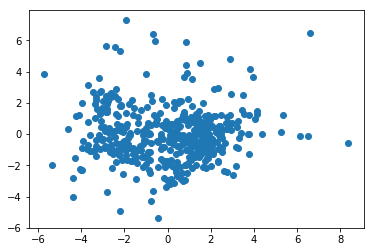

In [29]:
plt.scatter(data_pca[:, 0], data_pca[:, 1]);

#### PCAの分散説明率

[0.44237417 0.71894523 0.83511865 0.93129585 0.97705265 1.        ]


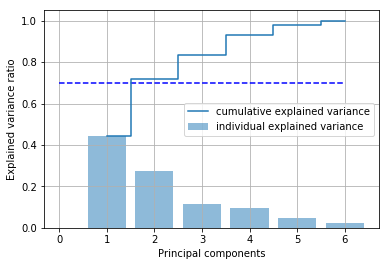

In [30]:
pca = PCA(n_components=None)
pca = pca.fit(df_spending_log)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

print(cum_var_exp)

plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

#### エルボー法

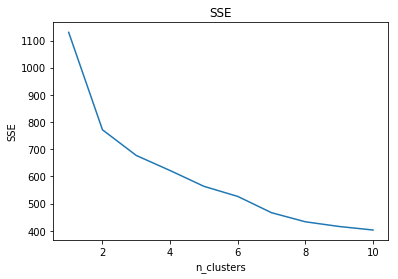

In [31]:
n_clusters = 10
sse = []

for i in range(1, n_clusters+1):
    clf = ScratchKMeans(max_iter=20, n_clusters = i)
    clf.fit(data_pca)
    sse.append(clf.loss)

plt.plot(np.arange(1, n_clusters+1), sse)
plt.title("SSE")
plt.xlabel("n_clusters")
plt.ylabel("SSE")
plt.show()

### クラスタリング（n=2）

In [32]:
clf_ws2 = ScratchKMeans(max_iter=20, n_clusters=2, random_state=0)

In [33]:
clf_ws2.fit(data_pca)

In [34]:
# 予測
ws2_pred = clf_ws2.predict(data_pca)

In [35]:
# クラスタの中心点
centers = clf_ws2.centers

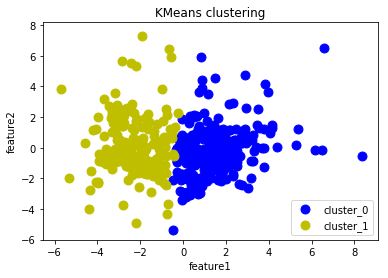

In [36]:
# パラメータ
target_names = ["0", "1", "2", "3", "4", "5"]
pred_color = ["b", "y", "r", "c", "b" "g"]
pred_names = ["cluster_" + target_name for target_name in target_names]

# 可視化
for i, target in enumerate(set(ws2_pred)):
    plt.scatter(data_pca[ws2_pred==target][:, 0], data_pca[ws2_pred==target][:, 1],
                    s=80, color=pred_color[target], label=pred_names[target], marker='o')

plt.title("KMeans clustering")
plt.xlabel("feature1")
plt.ylabel("feature2")
plt.legend()
plt.show()

In [37]:
# 各データ点のシルエット係数
silhouette_vals = clf_ws2.silhouette_vals

# シルエット係数の平均値
silhouette_avg = np.mean(silhouette_vals)

# 各データ点のクラスタラベル名
y_km = clf_ws2.label

# 各データポイントのラベル
cluster_labels = clf_ws2.cluster_labels

# クラスタ数
n_clusters = clf_ws2.n_clusters

yticks : [130.0]
yticks : [130.0, 350.0]


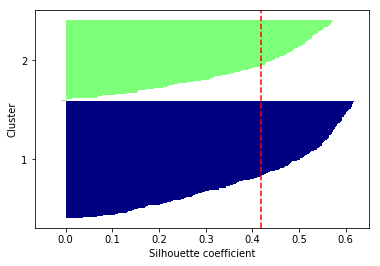

In [38]:
from matplotlib import cm

y_ax_lower, y_ax_upper = 0, 0
yticks = []

for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    print("yticks : {}".format(yticks))
    y_ax_lower += len(c_silhouette_vals)

plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, np.array(cluster_labels) + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()

### クラスタリング（n=3）

In [39]:
clf_ws3 = ScratchKMeans(max_iter=20, n_clusters=3, random_state=0)

In [40]:
clf_ws3.fit(data_pca)

In [41]:
# 予測
ws3_pred = clf_ws3.predict(data_pca)

In [42]:
centers = clf_ws3.centers

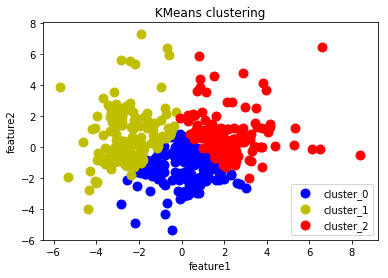

In [43]:
# パラメータ
target_names = ["0", "1", "2", "3", "4", "5"]
pred_color = ["b", "y", "r", "c", "b" "g"]
pred_names = ["cluster_" + target_name for target_name in target_names]

# 可視化
for i, target in enumerate(set(ws3_pred)):
    plt.scatter(data_pca[ws3_pred==target][:, 0], data_pca[ws3_pred==target][:, 1],
                    s=80, color=pred_color[target], label=pred_names[target], marker='o')

plt.title("KMeans clustering")
plt.xlabel("feature1")
plt.ylabel("feature2")
plt.legend()
plt.show()

In [44]:
# 各データ点のシルエット係数
silhouette_vals = clf_ws3.silhouette_vals

# シルエット係数の平均値
silhouette_avg = np.mean(silhouette_vals)

# 各データ点のクラスタラベル名
y_km = clf_ws3.label

# 各データポイントのラベル
cluster_labels = clf_ws3.cluster_labels

# クラスタ数
n_clusters = clf_ws3.n_clusters

yticks : [81.0]
yticks : [81.0, 228.0]
yticks : [81.0, 228.0, 367.0]


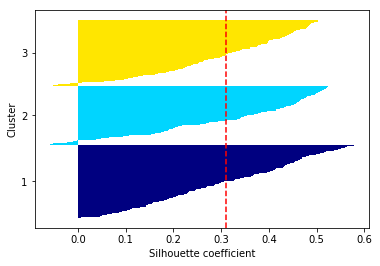

In [45]:
from matplotlib import cm

y_ax_lower, y_ax_upper = 0, 0
yticks = []

for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    print("yticks : {}".format(yticks))
    y_ax_lower += len(c_silhouette_vals)

plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, np.array(cluster_labels) + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()

以下の理由からクラスタ数<font color="blue">"**$n$ = 2**"</font>が最適と考える。

- $n$=2でPCAの分散説明率が0.7を超え、相応の説明力があると思われること。
- SSE（エルボー法）の減少率が、$n$=2以降で緩やかになること。
- $n$=2の平均シルエット係数（≒ 0.4）が、$n$=3の平均シルエット係数（≒ 0.3）を上回ること。

### 【問題5】既知のグループとの比較

RegionとChannelはK-meansに使用しなかったが、これらは既知のグループである。

クラスタとこれら既知のグループがどう違うかを確認し、説明する。（まずはそれぞれを可視化する）

### Region

In [46]:
label_region = df.Region

In [47]:
np.unique(label_region, return_counts=True)

(array([1, 2, 3]), array([ 77,  47, 316]))

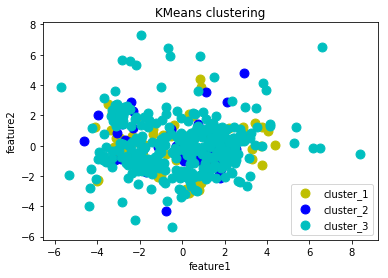

In [48]:
# パラメータ
target_names = ["0", "1", "2", "3", "4", "5"]
pred_color = ["r", "y", "b", "c", "b" "g"]

pred_names = ["cluster_" + target_name for target_name in target_names]

# 可視化
for i, target in enumerate(set(label_region)):
    plt.scatter(data_pca[label_region==target][:, 0], data_pca[label_region==target][:, 1],
                    s=80, color=pred_color[target], label=pred_names[target], marker='o')

plt.title("KMeans clustering")
plt.xlabel("feature1")
plt.ylabel("feature2")
plt.legend()
plt.show()

### Channels

In [49]:
label_channel = df.Channel

In [50]:
np.unique(label_channel, return_counts=True)

(array([1, 2]), array([298, 142]))

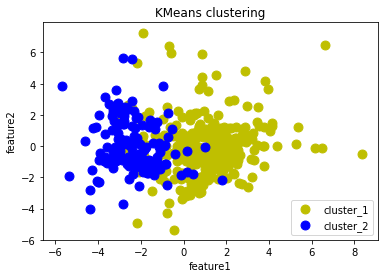

In [51]:
# パラメータ
target_names = ["0", "1", "2", "3", "4", "5"]
pred_color = ["r", "y", "b", "c", "b" "g"]
pred_names = ["cluster_" + target_name for target_name in target_names]

# 可視化
for i, target in enumerate(set(label_channel)):
    plt.scatter(data_pca[label_channel==target][:, 0], data_pca[label_channel==target][:, 1],
                    s=80, color=pred_color[target], label=pred_names[target], marker='o')

plt.title("KMeans clustering")
plt.xlabel("feature1")
plt.ylabel("feature2")
plt.legend()
plt.show()

上記散布図から、以下のことが確認された。

- "Region"毎の特徴量分布は、n=3でクラスタリングした結果と一致していない。
- "Channel"毎の特徴量分布が、n=2でクラスタリングした結果と概ね一致していることが確認された。

### 【問題6】卸売業者にとって有益な情報

卸売業者にとって有益な情報を探し出し文章にまとめること。

#### 得られる示唆

- 主成分分析、およびクラスタリングの結果、チャネル別で顧客の消費支出に差異が見られることが示唆された。

- これはマーケティング施策立案上、チャネル別に顧客をセグメンテーションすると効果が得られる可能性が高いことを意味する。

- チャネル別に顧客の購買特性（価格帯、要求される品質や機能性）を分析した上で、プロモーション、商品開発等の方針を決定すると良いと思われる。

### Take away

1. クラスタリングの用途：マーケティングの事例を通じて、以下の点が重要だと理解した。
    - 大量のデータがある場合、PCAにより次元削減を行うことで、データの比較が容易になる。
    - クラスタリングした結果を、元のデータ（pandas）に追加し、それぞれのクラスタがどの特徴量（今回の例ではChannelやRegion）を近似しているのか示唆を得る。
    - クラスタは、それぞれ特性（≒パラメータ）の異なる集団（顧客など）と捉えられる。それぞれのクラスタ毎に細分化して、特性や抱える課題を分析し、意味のある施策を考える。


2. アルゴリズムの肝 : 
    - 中心点の選定：クラスタ数と等しい数だけ、サンプルからランダムに抽出。
    - 凝集度、乖離度：同じクラスタに属するサンプル、あるいは、最も近いクラスタに属するサンプルとの平均距離で測定する。
    - シルエット図により、クラスタリングの当てはまりの良さを可視化することができる。